In [1]:
from __future__ import division, print_function
import sys, os, glob, gc, warnings
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
import matplotlib.pyplot as plt

from desitarget.targets import desi_mask

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
ramin, ramax = 260, 268
decmin, decmax = 11, 18

In [4]:
sweep_dir = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0'
resid_dir = '/global/cscratch1/sd/rongpu/desi/dr8_sweep_apflux_resid/south'

columns = ['TYPE', 'RA', 'DEC', 'EBV', 
          'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 
          'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 
          'NOBS_G', 'NOBS_R', 'NOBS_Z', 'NOBS_W1', 'NOBS_W2', 
          'FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_Z', 'FRACFLUX_W1', 'FRACFLUX_W2', 
          'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z', 'FRACIN_G', 'FRACIN_R', 'FRACIN_Z', 
          'WISEMASK_W1', 'WISEMASK_W2', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 
          'SHAPEEXP_R', 'SHAPEEXP_E1', 'SHAPEEXP_E2',
          'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z',
          'MASKBITS']

# Identify the corresponding sweep files
sweep_path_all = glob.glob(os.path.join(sweep_dir, '*.fits'))
sweep_fn_all = [os.path.basename(sweep_path_all[ii]) for ii in range(len(sweep_path_all))]
sweep_fn_list = []
for index in range(len(sweep_fn_all)):
    brick = sweep_fn_all[index][-20:-5]
    ra1min, ra1max = float(brick[0:3]), float(brick[8:11])
    dec1min = float(brick[4:7]) if brick[3]=='p' else -float(brick[4:7])
    dec1max = float(brick[-3:]) if brick[-4]=='p' else -float(brick[-3:])
    if (((ramin>=ra1min) & (ramin<ra1max)) | ((ramax>ra1min) & (ramax<=ra1max))) \
         & (((decmin>=dec1min) & (decmin<dec1max)) | ((decmax>dec1min) & (decmax<=dec1max))):
        sweep_fn_list.append(sweep_fn_all[index])
print(sweep_fn_list)

# Load sweep data and residual aperture fluxes
tmp_stack = []
for sweep_index in range(len(sweep_fn_list)):
    sweep_fn = sweep_fn_list[sweep_index]
    tmp = fitsio.read(os.path.join(sweep_dir, sweep_fn), columns=columns)
    tmp = Table(tmp)
    tmp1 = fitsio.read(os.path.join(resid_dir, sweep_fn[:-5]+'-resid.fits'))
    tmp1 = Table(tmp1)
    tmp = hstack([tmp, tmp1])
    
    mask = (tmp['RA']>ramin) & (tmp['RA']<ramax) & (tmp['DEC']>decmin) & (tmp['DEC']<decmax)
    # Requiring 2+ exposures in each band
    mask &= (tmp['NOBS_G']>=2) & (tmp['NOBS_R']>=2) & (tmp['NOBS_Z']>=2)
    tmp = tmp[mask]
    
    tmp_stack.append(tmp)
    gc.collect()

sweep = vstack(tmp_stack)
print(len(sweep))

['sweep-260p010-270p015.fits', 'sweep-260p015-270p020.fits']
5462834


__Original ELGs__

In [5]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sweep['gmag'] = 22.5 - 2.5*np.log10(sweep['FLUX_G']/sweep['MW_TRANSMISSION_G'])
    sweep['rmag'] = 22.5 - 2.5*np.log10(sweep['FLUX_R']/sweep['MW_TRANSMISSION_R'])
    sweep['zmag'] = 22.5 - 2.5*np.log10(sweep['FLUX_Z']/sweep['MW_TRANSMISSION_Z'])
    sweep['w1mag'] = 22.5 - 2.5*np.log10(sweep['FLUX_W1']/sweep['MW_TRANSMISSION_W1'])
    sweep['w2mag'] = 22.5 - 2.5*np.log10(sweep['FLUX_W2']/sweep['MW_TRANSMISSION_W2'])
    
# Apply ELG selection
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mask_elg = sweep['gmag'] > 20.0
    mask_elg &= sweep['gmag'] < 23.5
    mask_elg &= (sweep['rmag'] - sweep['zmag']) > 0.3
    mask_elg &= sweep['rmag'] - sweep['zmag'] < 1.6
    mask_elg &= sweep['gmag'] - sweep['rmag'] < 1.15 * (sweep['rmag'] - sweep['zmag']) - 0.15
    mask_elg &= sweep['gmag'] - sweep['rmag'] < -1.20 * (sweep['rmag'] - sweep['zmag']) + 1.6
    mask_elg &= ((sweep['MASKBITS'] & 2**5)==0) & ((sweep['MASKBITS'] & 2**6)==0) & ((sweep['MASKBITS'] & 2**7)==0)
    mask_elg &= ((sweep['MASKBITS'] & 2**1)==0) & ((sweep['MASKBITS'] & 2**11)==0) & ((sweep['MASKBITS'] & 2**12)==0) & ((sweep['MASKBITS'] & 2**13)==0)
print(np.sum(mask_elg))

74656


In [6]:
t = Table()
t['type'], t['counts'] = np.unique(sweep['TYPE'][mask_elg], return_counts=True)
t['frac (%)'] = t['counts']/np.sum(mask_elg)*100
t['frac (%)'].format = '%.1f'
print('All ELGs:')
print(t)

All ELGs:
type counts frac (%)
---- ------ --------
COMP     33      0.0
DEV    3616      4.8
EXP   12553     16.8
PSF   11818     15.8
REX   46636     62.5


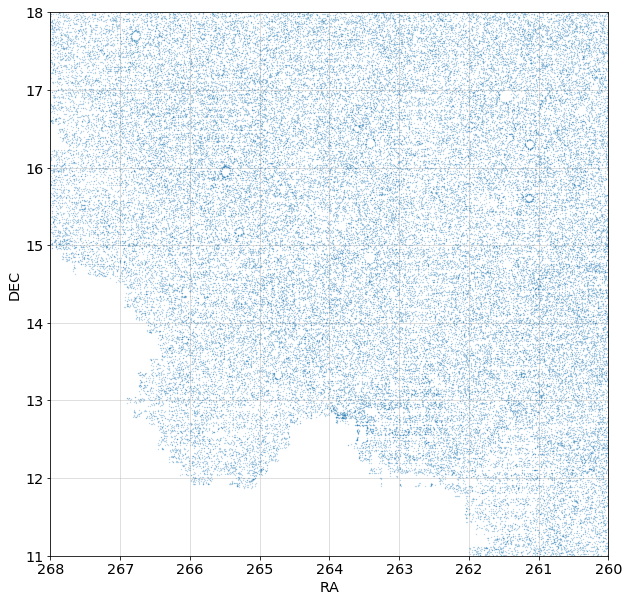

In [7]:
# Sky distribution of original ELGs
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(sweep['RA'][mask_elg], sweep['DEC'][mask_elg], '.', markersize=0.5, alpha=0.5)
ax.axis([ramax, ramin, decmin, decmax])
ax.grid(alpha=0.5)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
plt.show()

In [8]:
# Restrict to REX objects
mask = sweep['TYPE']=='REX '
sweep = sweep[mask]
mask_elg = mask_elg[mask]
print(len(sweep))

1127993


In [9]:
# # Plot sky distribution for different morphological types
# morph_types = ['REX ', 'EXP ', 'PSF ', 'DEV ']
# for morph_type in morph_types:
#     mask = mask_elg & (sweep['TYPE']==morph_type)
#     plt.figure(figsize=(10, 10))
#     plt.plot(sweep['RA'][mask], sweep['DEC'][mask], '.', markersize=1, alpha=0.6)
#     plt.title(morph_type)
#     plt.show()

__Apply local sky subtraction for REX objects and redo ELG selection__

In [10]:
sweep1 = sweep.copy()

r_half = sweep1['SHAPEEXP_R']

bands = ['g', 'r', 'z']
bands_cap = ['G', 'R', 'Z']

for band, band_cap in zip(bands, bands_cap): 
    sigma = sweep1['PSFSIZE_'+band_cap]/2.3548
    p = 1.15
    # noise equivalent area
    NEA = ((4 * np.pi * sigma**2)**(1/p) + (9.12 * r_half**2)**(1/p))**p
    # residual flux per sq arcsec
    sky_brightness = (sweep1['apflux_resid_'+band][:, -1]-sweep1['apflux_resid_'+band][:, -2]) / (np.pi*7**2-np.pi*5**2)
    sweep1['FLUX_'+band_cap] = sweep1['FLUX_'+band_cap] - NEA*sky_brightness

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sweep1['gmag'] = 22.5 - 2.5*np.log10(sweep1['FLUX_G']/sweep1['MW_TRANSMISSION_G'])
    sweep1['rmag'] = 22.5 - 2.5*np.log10(sweep1['FLUX_R']/sweep1['MW_TRANSMISSION_R'])
    sweep1['zmag'] = 22.5 - 2.5*np.log10(sweep1['FLUX_Z']/sweep1['MW_TRANSMISSION_Z'])
    sweep1['w1mag'] = 22.5 - 2.5*np.log10(sweep1['FLUX_W1']/sweep1['MW_TRANSMISSION_W1'])
    sweep1['w2mag'] = 22.5 - 2.5*np.log10(sweep1['FLUX_W2']/sweep1['MW_TRANSMISSION_W2'])
    
# Apply ELG selection
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mask_elg1 = sweep1['gmag'] > 20.0
    mask_elg1 &= sweep1['gmag'] < 23.5
    mask_elg1 &= (sweep1['rmag'] - sweep1['zmag']) > 0.3
    mask_elg1 &= sweep1['rmag'] - sweep1['zmag'] < 1.6
    mask_elg1 &= sweep1['gmag'] - sweep1['rmag'] < 1.15 * (sweep1['rmag'] - sweep1['zmag']) - 0.15
    mask_elg1 &= sweep1['gmag'] - sweep1['rmag'] < -1.20 * (sweep1['rmag'] - sweep1['zmag']) + 1.6
    mask_elg1 &= ((sweep1['MASKBITS'] & 2**5)==0) & ((sweep1['MASKBITS'] & 2**6)==0) & ((sweep1['MASKBITS'] & 2**7)==0)
    mask_elg1 &= ((sweep1['MASKBITS'] & 2**1)==0) & ((sweep1['MASKBITS'] & 2**11)==0) & ((sweep1['MASKBITS'] & 2**12)==0) & ((sweep1['MASKBITS'] & 2**13)==0)
print(np.sum(mask_elg1))

48211


In [12]:
# Compare with the number of original REX ELGs
print(np.sum(mask_elg))
print(np.sum(mask_elg1)/np.sum(mask_elg))

46636
1.03377219316


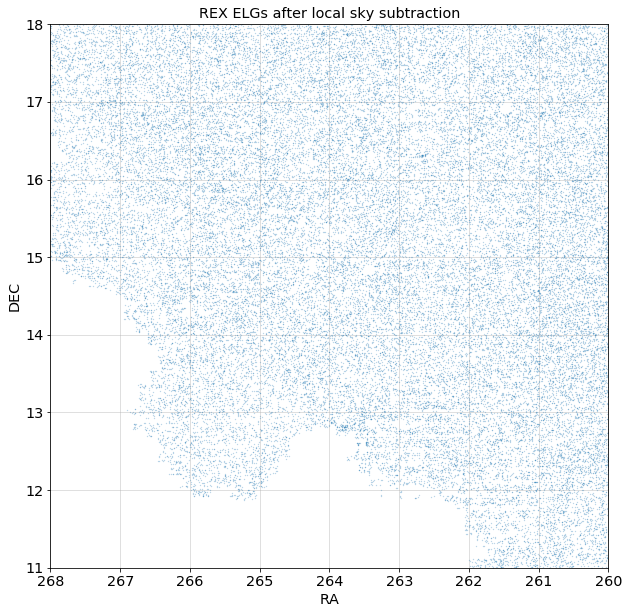

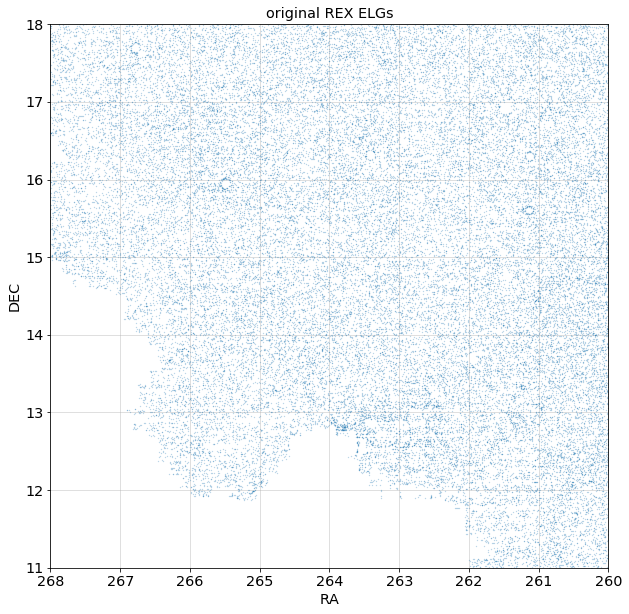

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sweep1['RA'][mask_elg1], sweep1['DEC'][mask_elg1], '.', markersize=0.5, alpha=0.5)
ax.axis([ramax, ramin, decmin, decmax])
ax.grid(alpha=0.5)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title('REX ELGs after local sky subtraction')
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sweep['RA'][mask_elg], sweep['DEC'][mask_elg], '.', markersize=0.5, alpha=0.5)
ax.axis([ramax, ramin, decmin, decmax])
ax.grid(alpha=0.5)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title('original REX ELGs')
plt.show()

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


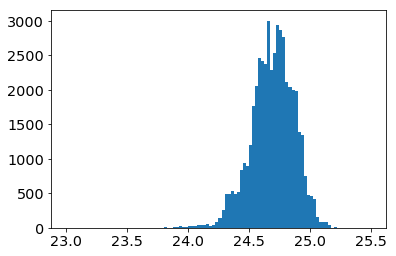

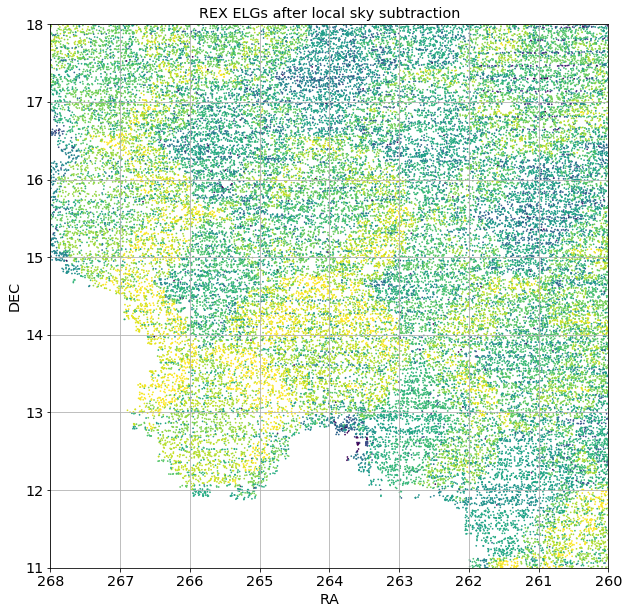

In [14]:
# Plot g-band depth variation

sweep1['gdepth'] = -2.5*(np.log10((5/np.sqrt(sweep1['GALDEPTH_G'])))-9)
mask = mask_elg1 & np.isfinite(sweep1['gdepth'])
plt.hist(sweep1['gdepth'][mask], 100, range=(23, 25.5));

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.scatter(sweep1['RA'][mask], sweep1['DEC'][mask], c=sweep1['gdepth'][mask], s=0.5, alpha=1., vmin=24, vmax=25)
ax.axis([ramax, ramin, decmin, decmax])
ax.grid(alpha=1.)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title('REX ELGs after local sky subtraction')
# fig.colorbar(im)
plt.show()

In [15]:
# # Load the "official" target catalog as a sanity check

# cat_list = glob.glob('/global/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/noresolve/*.fits')
# print(len(cat_list))

# index = 0
# while index<len(cat_list):
#     # print('wscnd' in cat_list[index])
#     if 'wscnd' in cat_list[index]:
#         print(cat_list[index])
#         cat_list.pop(index)
#     else:
#         index += 1

# cat_stack = []
# for index in range(len(cat_list)):
# # for index in range(10):
#     cat_chunk = fitsio.read(cat_list[index], columns=['RA', 'DEC', 'DESI_TARGET', 'PHOTSYS', 'NOBS_G', 'NOBS_R', 'NOBS_Z'])
#     mask = ((cat_chunk['DESI_TARGET'] & desi_mask['ELG'])!=0) & (cat_chunk['PHOTSYS']==b'S')
#     mask &= (cat_chunk['RA']>ramin) & (cat_chunk['RA']<ramax) & (cat_chunk['DEC']>decmin) & (cat_chunk['DEC']<decmax)
#     mask &= (cat_chunk['NOBS_G']>=2) & (cat_chunk['NOBS_R']>=2) & (cat_chunk['NOBS_Z']>=2)
#     if np.sum(mask)>0:
#         idx = np.where(mask)[0]
#         cat_chunk = fitsio.read(cat_list[index], rows=idx, 
#                                 columns=['RA', 'DEC', 'DESI_TARGET', 'MASKBITS', 'MORPHTYPE', 'FLUX_G', 'MW_TRANSMISSION_G', 'FRACDEV', 'SHAPEEXP_R', 'SHAPEEXP_E1', 'SHAPEEXP_E2', 'SHAPEDEV_E1', 'SHAPEDEV_E2'])
#         cat_chunk = Table(cat_chunk)
#         cat_stack.append(cat_chunk)
#         # print(len(cat_chunk))
#     gc.collect()
    
# cat = vstack(cat_stack)
# print(len(cat))

# t = Table()
# t['type'], t['counts'] = np.unique(cat['MORPHTYPE'], return_counts=True)
# t['frac (%)'] = t['counts']/len(cat)*100
# t['frac (%)'].format = '%.1f'
# t.sort('counts')
# print('All ELGs:')
# print(t)

# fig, ax = plt.subplots(figsize=(10, 10))
# ax.plot(cat['RA'], cat['DEC'], '.', markersize=0.5, alpha=0.5)
# ax.axis([ramax, ramin, decmin, decmax])
# ax.grid(alpha=0.5)
# ax.set_xlabel('RA')
# ax.set_ylabel('DEC')
# plt.show()

All objects:
g-band median flux offset: 0.0078


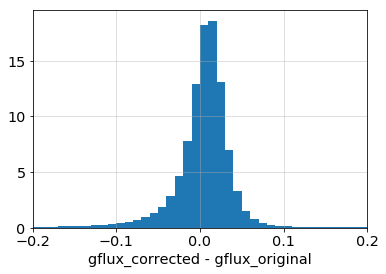

r-band median flux offset: 0.0115


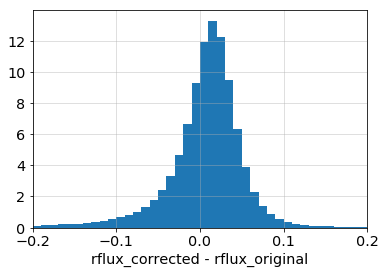

z-band median flux offset: 0.0145


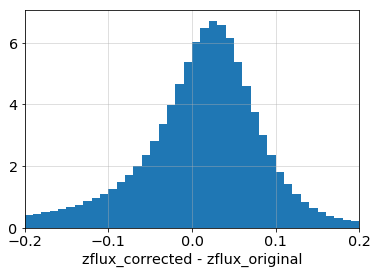


g-band median magnitude offset: -0.0335


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in subtract


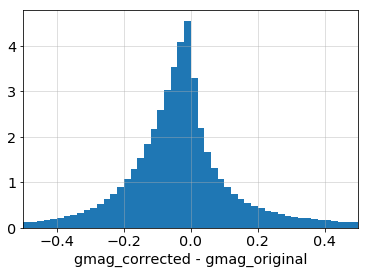

r-band median magnitude offset: -0.0214


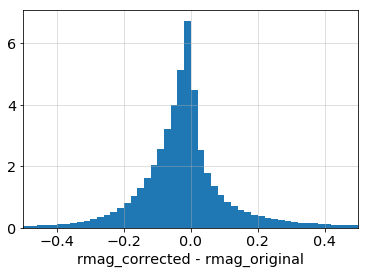

z-band median magnitude offset: -0.0107


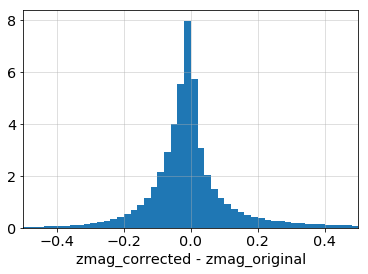

In [16]:
# distribution of flux and magnitude differences for all sweep objects
print('All objects:')

for band, band_cap in zip(bands, bands_cap): 
    x = sweep1['FLUX_'+band_cap]-sweep['FLUX_'+band_cap]
    print('{}-band median flux offset: {:.4f}'.format(band, np.median(x)))
    plt.hist(x, 100, range=(-0.5, 0.5), density=True)
    plt.grid(alpha=0.5)
    plt.xlabel(band+'flux_corrected - '+band+'flux_original')
    plt.xlim(-0.2, 0.2)
    plt.show()
print()

for band, band_cap in zip(bands, bands_cap): 
    x = sweep1[band+'mag']-sweep[band+'mag']
    print('{}-band median magnitude offset: {:.4f}'.format(band, np.median(x[np.isfinite(x)])))
    plt.hist(x[np.isfinite(x)], 100, range=(-1, 1), density=True)
    plt.grid(alpha=0.5)
    plt.xlabel(band+'mag_corrected - '+band+'mag_original')
    plt.xlim(-0.5, 0.5)
    plt.show()

original ELGs objects:
g-band median flux offset: 0.0047


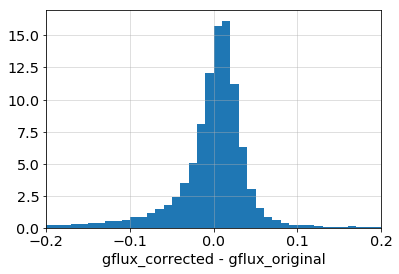

r-band median flux offset: 0.0098


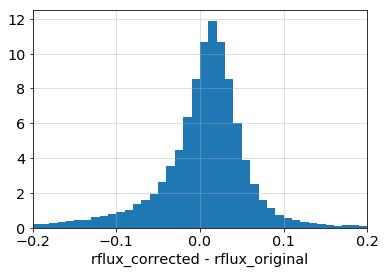

z-band median flux offset: 0.0124


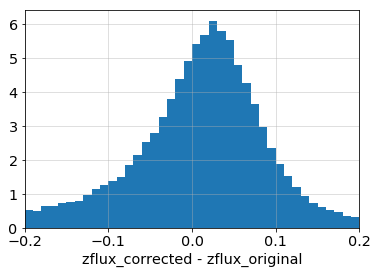


g-band median magnitude offset: -0.0122


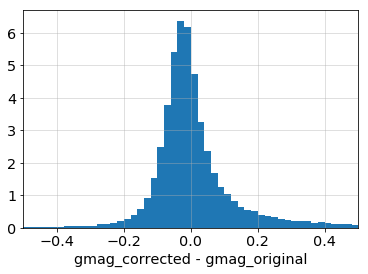

r-band median magnitude offset: -0.0175


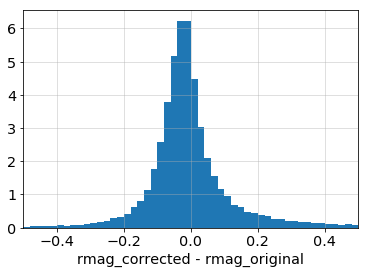

z-band median magnitude offset: -0.0106


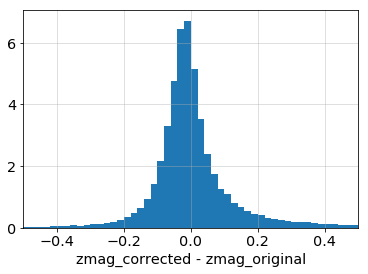

In [18]:
# distribution of flux and magnitude differences for original ELGs
print('original ELGs objects:')

for band, band_cap in zip(bands, bands_cap): 
    x = sweep1['FLUX_'+band_cap][mask_elg]-sweep['FLUX_'+band_cap][mask_elg]
    print('{}-band median flux offset: {:.4f}'.format(band, np.median(x)))
    plt.hist(x, 100, range=(-0.5, 0.5), density=True)
    plt.grid(alpha=0.5)
    plt.xlabel(band+'flux_corrected - '+band+'flux_original')
    plt.xlim(-0.2, 0.2)
    plt.show()
print()

for band, band_cap in zip(bands, bands_cap): 
    x = sweep1[band+'mag'][mask_elg]-sweep[band+'mag'][mask_elg]
    print('{}-band median magnitude offset: {:.4f}'.format(band, np.median(x[np.isfinite(x)])))
    plt.hist(x[np.isfinite(x)], 100, range=(-1, 1), density=True)
    plt.grid(alpha=0.5)
    plt.xlabel(band+'mag_corrected - '+band+'mag_original')
    plt.xlim(-0.5, 0.5)
    plt.show()